In [387]:
# Authors: Rahul Ramachandran and Rishit D

# Importing the required libraries
try:
    import numpy as np
    import pandas as pd
    import ucimlrepo
    from sklearn.linear_model import LinearRegression
    from statsmodels.miscmodels.ordinal_model import OrderedModel
except:
    print(f'[INFO] Installing the required libraries')
    !pip install numpy
    !pip install pandas
    !pip install ucimlrepo
    !pip install scikit-learn
    !pip install statsmodels
    import numpy as np
    import pandas as pd
    import ucimlrepo
    from sklearn.linear_model import LinearRegression
    from statsmodels.miscmodels.ordinal_model import OrderedModel


In [388]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
print(f'[INFO] Dataset loaded successfully')

# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

# metadata 
print(wine_quality.metadata) 
# variable information 
print(wine_quality.variables) 

[INFO] Dataset loaded successfully
{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine prefe

In [395]:
# Function which evaluates
def evaluate(y_true, y_pred, pred_type:str, verbose:bool=True):
    """Prints the evaluation metrics for the model. 
    This includes:
        Mean Absolute Error (MAE), Mean Squared Error (MSE), Ratio of Correct Predictions, Almost Correct Predictions (Difference of 1)
    params:
        y_true: The true labels (np.array or pandas dataframe of predicted class (shape: (n, 1)) or probabilities (shape: (n, c)))
        y_pred: The predicted labels (np.array or pandas dataframe of predicted class (shape: (n, 1)))
        pred_type: The type of y_true (either 'probs' or 'labels')
    """
    assert pred_type == 'probs' or pred_type == 'labels', "type must be either 'probs' or 'labels'"

    if pred_type == 'labels':
        pred, gt = y_pred, y_true
        if verbose:
            print(f'MAE: {np.mean(np.abs(pred - gt))}')
            print(f'MSE: {np.mean((pred - gt)**2)}')
            print(f'Correct Predictions: {np.sum(np.rint(pred) == gt)} out of {len(gt)}')
            print(f'Almost Correct Predictions: {np.sum(np.abs(np.rint(pred) - gt) <= 1)} out of {len(gt)}')
        return np.sum(np.rint(pred) == gt)/len(gt)
    else:
        probs, gt = y_pred, y_true
        pred = np.sum(probs * np.array(list(range(int(y.min().iloc[0]), int(y.max().iloc[0])+1))), axis=1)[:, np.newaxis] # predictions are expected values of the distribution
        if verbose:
            print(f'MAE: {np.mean(np.abs(pred - gt))}')
            print(f'MSE: {np.mean((pred - gt)**2)}')
            print(f'Correct Predictions: {np.sum((probs.argmax(1) + 3)[:, np.newaxis] == gt)} out of {len(gt)}')
            print(f'Almost Correct Predictions: {np.sum(np.abs((probs.argmax(1) + 3)[:, np.newaxis] - gt) <= 1)} out of {len(gt)}')
        return np.sum((probs.argmax(1) + 3)[:, np.newaxis] == gt)/len(gt)

In [396]:
# Prepare training and testing data
from sklearn.model_selection import train_test_split

# Join X and y, stratify based on y
data = pd.concat([X, y], axis=1)
# data_train = data.sample(frac=0.8, random_state=42)
# X_train = data_train.iloc[:, :-1]
# y_train = data_train.iloc[:, -1]

# data_test = data.drop(data_train.index)
# X_test = data_test.iloc[:, :-1]
# y_test = data_test.iloc[:, -1]

# stratified_data = train_test_split(data, test_size=0.2, stratify=y, random_state=100)
# train, test = stratified_data
# X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
# X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

nX, ny = len(X), len(y)
train_size = int(0.8 * nX)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [397]:
# Fit the Linear Regression Model
reg_model = LinearRegression().fit(X_train, y_train)
print(f'Linear Regression Score: {reg_model.score(X_train, y_train)}')

Linear Regression Score: 0.29926906612869675


In [398]:
# Evaluate the Linear Regression Model
pred, gt = np.array(reg_model.predict(X_test))[:, np.newaxis], np.array(y_test)[:, np.newaxis]
acc = evaluate(gt, pred, 'labels')

MAE: 0.5513533210016455
MSE: 0.507210463667933
Correct Predictions: 518 out of 980
Almost Correct Predictions: 942 out of 980


In [399]:
from pandas.api.types import CategoricalDtype

# Create an ordered categorical type for ordinal regression
print(f'Range of values: {int(y.min().iloc[0])} to {int(y.max().iloc[0])}')
ctype = CategoricalDtype(categories=list(range(int(y.min().iloc[0]), int(y.max().iloc[0])+1)), ordered=True)
y_train = y_train.astype(ctype)

Range of values: 3 to 9


In [406]:
# Fit the Ordinal Regression Model

# CLogLog for proportional hazards
class CLogLog(stats.rv_continuous):
    def _ppf(self, q):
        return np.log(-np.log(1 - q))

    def _cdf(self, x):
        return 1 - np.exp(-np.exp(x))


cloglog = CLogLog()

ord_model = OrderedModel(y_train, X_train, distr=cloglog)
ord_model = ord_model.fit(method='bfgs', maxiter=10000)

# import mord 

# ord_model = mord.OrdinalRidge(alpha=5)
# ord_model.fit(np.array(X_train), np.array(y_train))

Optimization terminated successfully.
         Current function value: 1.154877
         Iterations: 132
         Function evaluations: 138
         Gradient evaluations: 138


In [407]:
# Evaluate the Ordinal Regression Model
probs, gt = np.array(ord_model.model.predict(ord_model.params, X_test)), np.array(y_test)
evaluate(gt, probs, 'probs')

# pred, gt = np.array(ord_model.predict(np.array(X_test)))[:, np.newaxis], np.array(y_test)[:, np.newaxis]
# acc = evaluate(gt, pred, 'labels')

MAE: 0.5371400005088605
MSE: 0.4860243626072449
Correct Predictions: 553 out of 980
Almost Correct Predictions: 949 out of 980


0.5642857142857143

(array([  1,  25, 266, 517, 151,  20,   0]), array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


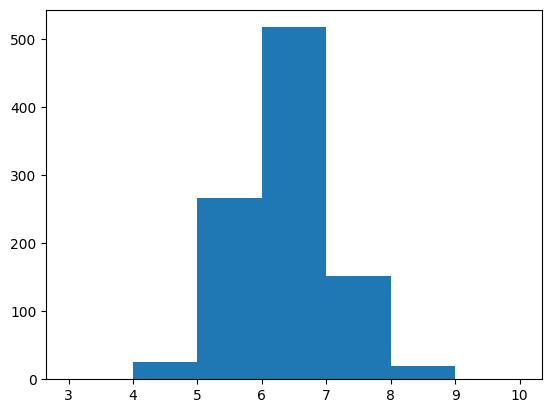

In [ ]:
# print(np.histogram(y_test, bins=7))
# print(np.histogram(y_train, bins=7))
import matplotlib.pyplot as plt
plt.hist(y_test, bins=7, range=(3, 10))
print(np.histogram(y_test, bins=7, range=(3, 10)))
plt.show()

(array([  19,  138, 1191, 1681,  729,  155,    5]), array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


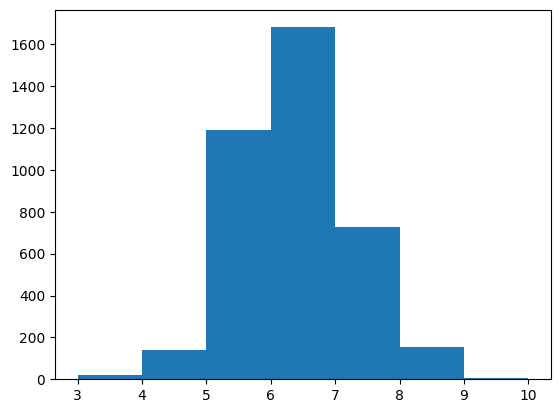

In [ ]:
plt.hist(y_train, bins=7, range=(3, 10))
print(np.histogram(y_train, bins=7, range=(3, 10)))
plt.show()

ValueError: x must have 2 or fewer dimensions

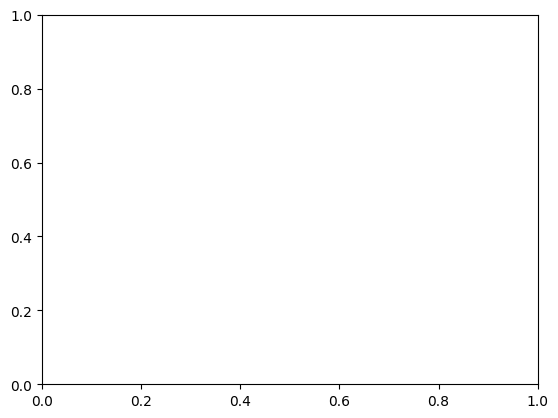

In [ ]:
plt.hist(pred, bins=7, range=(3, 10))
print(np.histogram(pred, bins=7, range=(3, 10)))
plt.show()